# Tutorial Part 02 - How to formulate QUBOs by hand using Polynomials

In [1]:
import networkx as nx
import numpy as np
import pytest

In [2]:
from quark import Polynomial, PolyBinary, PolyIsing

## What we will learn

In this tutorial, we will learn

 1. how to use the ``Polynomial`` class to formulate arbitrary combinatorial optimization problems as a quadratic unconstrained binary optimization problem (QUBO) at the example of the Maximum k-colorable Subgraph Problem, 
 2. how to deal with QUBO solutions and 
 3. how to convert the QUBO and its solution to Ising form and back.

## 1. Formulation of the Max-$k$-colorable Subgraph Problem as a QUBO

### The example problem: Max-$k$-Colorable Subgraph Problem ###

We have a given set of edges $E$ of a graph implicitly given by a list of $(n,m)$, which are tuples of two connected nodes. 

Furthermore the number of maximum colors available is given by a constant $k$. 

For a given graph, the Maximum k-Colorable Subgraph Problem is the problem of determining the largest set of nodes of the graph, that can be colored using $k$ distinct colors such that adjacent nodes are assigned different colors.

More information can be found in the paper [Paper](https://minds.wisconsin.edu/handle/1793/59158) or on [Wikipedia](https://en.wikipedia.org/wiki/Graph_coloring).

### Problem formulation

In the following we show how the problem is formulated in order to be properly stated as a Quadratic Unconstrained Binary Optimization Problem (QUBO). 


#### Example graph 

For example we might be given the following data

In [3]:
edges = [('a', 'b'), ('b', 'c'), ('b', 'd'), ('c', 'd')]
num_colors = 3 

from which we get the example graph

In [4]:
G = nx.Graph()
G.add_edges_from(edges)

and a possible coloring of the nodes would be

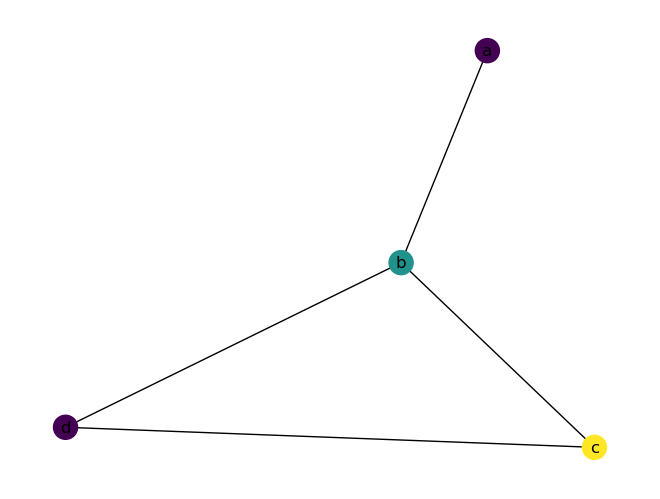

In [5]:
colors = [node_index % num_colors for node_index in range(len(G.nodes))]
nx.draw(G, node_color=colors, with_labels=True)

#### Decision variable

We introduce a binary variable $$x_{nc} = \begin{cases}
    1, &\text{if node $n$ is colored with color $c$},\\
    0, &\text{otherwise}
\end{cases}$$
for all $n \in N$ and $c \in \{0, ..., k-1\}$.

For example of the above graph $G$, the decision variable matrix looks like: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;node $n$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a&nbsp;&nbsp;&nbsp;&nbsp;b&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;d

color $c$ $~~~\begin{array}{c} 0 \\ 1 \\ 2 \\ \end{array}$ $\left[\begin{array}{cccc} 1 & 0 & 0 & 1\\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0 \end{array}\right]$ $~~~\begin{array}{l} (violett)\\ (petrol)\\ (yellow)\\ \end{array}$


#### ILP

We want to find the largest graph colored with $k$ colors or in turn we want to minimize the number of wrongly colored edges. Thus, the cost function counts the number of not properly colored edges. It is zero if all edges are colored properly:

$$C(x) = \sum_{(n, m)\in E} \sum_{c=0}^{k-1} x_{nc} x_{mc}.$$

As only one color can be set per node, we have the constraints
$$ \sum_{c=0}^{k-1} x_{nc} = 1 \quad\forall n \in N.$$

Thus the full optimization problem is 

\begin{align}
    &\min &&C(x) \\
    &s.t. &&\sum_{c=0}^{k-1} x_{nc} = 1 \quad\forall n \in N, \\
          &&&x \in \{0, 1\}^{N \times k}.
\end{align}

#### QUBO

The constraint can be written as an additional term in the cost function
$$ C_{\text{one}}(x) = \sum_{n \in N} \left(\sum_{c=0}^{k-1} x_{nc} - 1 \right)^2.$$

So the full objective function is

$$Q(x) = C(x) + \lambda_{\text{one}} C_{\text{one}}(x)$$

and thus the QUBO is

$$\min Q(x) \qquad \text{for } x \in \{0, 1\}^{N \times k},$$

where $\lambda_{\text{one}}$ is a weight that defines the contribution of the constraint (the penalty) to the whole term.

### Construction of the QUBO as Polynomial terms ##
Now we can construct our QUBO as a ``Polynomial``. Infact, since we know that the variables $x_{nc}$ are binary, we will use ``PolyBinary``.

The first contribution of the QUBO, $\displaystyle C = \sum_{(n, m)\in E} \sum_{c=0}^{k-1} x_{nc} x_{mc}$, can be implemented as

In [6]:
X = "x"   # name of the variable

In [7]:
objective_poly = PolyBinary()
for color in range(num_colors):
    for node_1, node_2 in edges:
        objective_poly += PolyBinary({((X, node_1, color), (X, node_2, color)): 1.0})
objective_poly.to_string()

'+1 x_a_0 x_b_0 +1 x_a_1 x_b_1 +1 x_a_2 x_b_2 +1 x_b_0 x_c_0 +1 x_b_0 x_d_0 +1 x_b_1 x_c_1 +1 x_b_1 x_d_1 +1 x_b_2 x_c_2 +1 x_b_2 x_d_2 +1 x_c_0 x_d_0 +1 x_c_1 x_d_1 +1 x_c_2 x_d_2'

Because the added monomials have disjoint variable pairs, we can even simplify this to

In [8]:
objective_poly = PolyBinary({((X, node_1, color), (X, node_2, color)): 1.0 for color in range(num_colors)
                                                                           for node_1, node_2 in edges})
objective_poly.to_string()

'+1 x_a_0 x_b_0 +1 x_a_1 x_b_1 +1 x_a_2 x_b_2 +1 x_b_0 x_c_0 +1 x_b_0 x_d_0 +1 x_b_1 x_c_1 +1 x_b_1 x_d_1 +1 x_b_2 x_c_2 +1 x_b_2 x_d_2 +1 x_c_0 x_d_0 +1 x_c_1 x_d_1 +1 x_c_2 x_d_2'

And the second contribution, the penalty term $C_{\text{one}} = \displaystyle \sum_{n \in N} \left(\sum_{c = 0}^{k-1} x_{nc} - 1 \right)^2$, can be implemented as

In [9]:
penalty_poly = PolyBinary()
for node in G.nodes:
    penalty_poly_node = -1 + PolyBinary({((X, node, color),): 1 for color in range(num_colors)})
    penalty_poly += penalty_poly_node * penalty_poly_node
    
penalty_poly.to_string()

'+4 -1 x_a_0 -1 x_a_1 -1 x_a_2 -1 x_b_0 -1 x_b_1 -1 x_b_2 -1 x_c_0 -1 x_c_1 -1 x_c_2 -1 x_d_0 -1 x_d_1 -1 x_d_2 +2 x_a_0 x_a_1 +2 x_a_0 x_a_2 +2 x_a_1 x_a_2 +2 x_b_0 x_b_1 +2 x_b_0 x_b_2 +2 x_b_1 x_b_2 +2 x_c_0 x_c_1 +2 x_c_0 x_c_2 +2 x_c_1 x_c_2 +2 x_d_0 x_d_1 +2 x_d_0 x_d_2 +2 x_d_1 x_d_2'

By furthermore assigning a weight value $\lambda_{\text{one}} = 10 $


In [10]:
penalty_weight = 10.0

The full QUBO $Q(x) = C(x) + \lambda_{\text{one}} C_{\text{one}}(x)$ then is 

In [11]:
qubo = objective_poly + penalty_weight * penalty_poly
qubo.to_string()

'+40 -10 x_a_0 -10 x_a_1 -10 x_a_2 -10 x_b_0 -10 x_b_1 -10 x_b_2 -10 x_c_0 -10 x_c_1 -10 x_c_2 -10 x_d_0 -10 x_d_1 -10 x_d_2 +20 x_a_0 x_a_1 +20 x_a_0 x_a_2 +1 x_a_0 x_b_0 +20 x_a_1 x_a_2 +1 x_a_1 x_b_1 +1 x_a_2 x_b_2 +20 x_b_0 x_b_1 +20 x_b_0 x_b_2 +1 x_b_0 x_c_0 +1 x_b_0 x_d_0 +20 x_b_1 x_b_2 +1 x_b_1 x_c_1 +1 x_b_1 x_d_1 +1 x_b_2 x_c_2 +1 x_b_2 x_d_2 +20 x_c_0 x_c_1 +20 x_c_0 x_c_2 +1 x_c_0 x_d_0 +20 x_c_1 x_c_2 +1 x_c_1 x_d_1 +1 x_c_2 x_d_2 +20 x_d_0 x_d_1 +20 x_d_0 x_d_2 +20 x_d_1 x_d_2'

### Flatten the QUBO ##

A quantum solver for the QUBO might need the QUBO in the matrix form $Q(x) = \sum_{ij} M_{ij} x_i x_j$, i.e. with *compact* indices.

Therefore we have to map the binary variable $x_{nc}$ which depends on two indices $n$ and $c$ to a single-variant binary variable $x_j$ with 

$$ (n, c) \mapsto j $$

for $j \in \{0, |N| \cdot k - 1\}$.  

We have the variables

In [12]:
qubo.variables

[('x', 'a', 0),
 ('x', 'a', 1),
 ('x', 'a', 2),
 ('x', 'b', 0),
 ('x', 'b', 1),
 ('x', 'b', 2),
 ('x', 'c', 0),
 ('x', 'c', 1),
 ('x', 'c', 2),
 ('x', 'd', 0),
 ('x', 'd', 1),
 ('x', 'd', 2)]

This ordering defines the concrete mapping, which executed by 

In [13]:
qubo_compact = qubo.compact()
qubo_compact.to_string()

'+40 -10 x0 -10 x1 -10 x2 -10 x3 -10 x4 -10 x5 -10 x6 -10 x7 -10 x8 -10 x9 -10 x10 -10 x11 +20 x0 x1 +20 x0 x2 +1 x0 x3 +20 x1 x2 +1 x1 x4 +1 x2 x5 +20 x3 x4 +20 x3 x5 +1 x3 x6 +1 x3 x9 +20 x4 x5 +1 x4 x7 +1 x4 x10 +1 x5 x8 +1 x5 x11 +20 x6 x7 +20 x6 x8 +1 x6 x9 +20 x7 x8 +1 x7 x10 +1 x8 x11 +20 x9 x10 +20 x9 x11 +20 x10 x11'

This can now be used to transform the objective function into the standard matrix format 

$$\sum_{ij} M_{ij} x_i x_j$$

In this example, we have

In [14]:
with pytest.warns(UserWarning, match="Constant offset of 40.0 is dropped"):
    M = qubo_compact.get_matrix_representation()
M

array([[-10.,  20.,  20.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [  0., -10.,  20.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0., -10.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [  0.,   0.,   0., -10.,  20.,  20.,   1.,   0.,   0.,   1.,   0.,
          0.],
       [  0.,   0.,   0.,   0., -10.,  20.,   0.,   1.,   0.,   0.,   1.,
          0.],
       [  0.,   0.,   0.,   0.,   0., -10.,   0.,   0.,   1.,   0.,   0.,
          1.],
       [  0.,   0.,   0.,   0.,   0.,   0., -10.,  20.,  20.,   1.,   0.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20.,   0.,   1.,
          0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.,   0.,
          1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20.,
         20.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,
         20.],
       [  0.,   0.,  

## 2. QUBO solutions

### Solution of the flattened QUBO ##

Now, we can solve the flattend QUBO, e.g. with a quantum annealer. The result will be a list of $0$ and $1$, for demonstration purposes we will use a random solution here

In [15]:
solution_qubo_compact = np.array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,])

### Solution evaluation with original QUBO

Then we can convert the solution back to a QUBO solution. Before we do that, the solution has to be represented as a dictionary:

In [16]:
var_assignment_qubo_compact = {k: v for k, v in enumerate(solution_qubo_compact)}
var_assignment_qubo_compact

{0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0}

And then unflatten the qubo solution

In [17]:
var_assignment_qubo = dict(zip(qubo.variables, var_assignment_qubo_compact.values()))
var_assignment_qubo

{('x', 'a', 0): 0,
 ('x', 'a', 1): 0,
 ('x', 'a', 2): 1,
 ('x', 'b', 0): 1,
 ('x', 'b', 1): 0,
 ('x', 'b', 2): 0,
 ('x', 'c', 0): 0,
 ('x', 'c', 1): 0,
 ('x', 'c', 2): 1,
 ('x', 'd', 0): 1,
 ('x', 'd', 1): 0,
 ('x', 'd', 2): 0}

Now, we can calculate the objective value of this solution by

In [18]:
obj_value = qubo.evaluate(var_assignment_qubo)
obj_value

1.0

Note, that since we chose a random solution, the constraints may be violated. We can check this, by calculating the objective value of both terms

In [19]:
objective_poly.evaluate(var_assignment_qubo)

1.0

In [20]:
penalty_poly.evaluate(var_assignment_qubo)

0

By rendering the assigned colors as a graph we also can see that the solution is valid in terms of the constraint requiring only one color per node. However the solution is not optimal as there is one edge which is not colored properly. However, we have seen above there exists such a solution. 

In [21]:
color_assignments = {node : color for (_, node, color), value in var_assignment_qubo.items() if value == 1}
color_assignments

{'a': 2, 'b': 0, 'c': 2, 'd': 0}

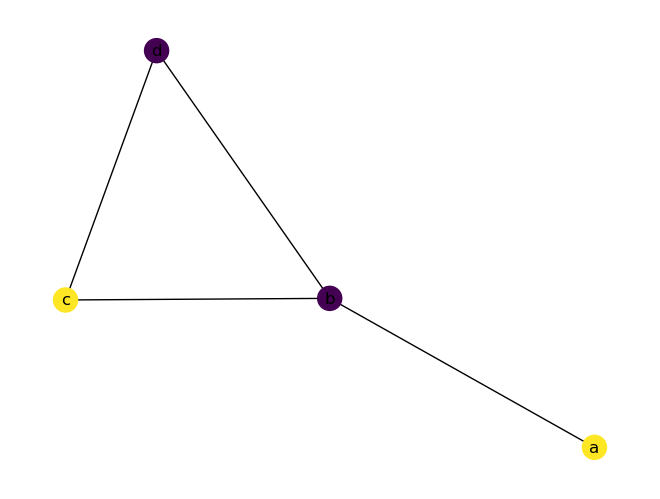

In [22]:
nx.draw(nx.Graph(edges),node_color=list(color_assignments.values()), with_labels=True)

## 3. Conversion of the QUBO and its solution to Ising form and back

Often it is desirable to convert a general QUBO

$$
\min \sum_{ij} Q_{ij} x_i x_j \qquad \text{for } x_i \in \{0, 1\}
$$

to the Ising form. Here we use the convention from the [D-Wave API](https://docs.ocean.dwavesys.com/en/stable/)

$$
x_i = \frac{s_i + 1}{2}, 
$$

which results in an Ising model 

$$
\min \sum_{i} h_{i} s_i + \sum_{ij} J_{ij} s_i s_j \qquad \text{for } s_i \in \{-1, 1\}.
$$

This is the actual model which is solved by the D-Wave machine.

In [23]:
ising_poly = qubo.to_ising()
ising_poly.to_string()

'+43 +5.25 x_a_0 +5.25 x_a_1 +5.25 x_a_2 +5.75 x_b_0 +5.75 x_b_1 +5.75 x_b_2 +5.5 x_c_0 +5.5 x_c_1 +5.5 x_c_2 +5.5 x_d_0 +5.5 x_d_1 +5.5 x_d_2 +5 x_a_0 x_a_1 +5 x_a_0 x_a_2 +0.25 x_a_0 x_b_0 +5 x_a_1 x_a_2 +0.25 x_a_1 x_b_1 +0.25 x_a_2 x_b_2 +5 x_b_0 x_b_1 +5 x_b_0 x_b_2 +0.25 x_b_0 x_c_0 +0.25 x_b_0 x_d_0 +5 x_b_1 x_b_2 +0.25 x_b_1 x_c_1 +0.25 x_b_1 x_d_1 +0.25 x_b_2 x_c_2 +0.25 x_b_2 x_d_2 +5 x_c_0 x_c_1 +5 x_c_0 x_c_2 +0.25 x_c_0 x_d_0 +5 x_c_1 x_c_2 +0.25 x_c_1 x_d_1 +0.25 x_c_2 x_d_2 +5 x_d_0 x_d_1 +5 x_d_0 x_d_2 +5 x_d_1 x_d_2'

where we have the corresponding compact Ising model 

In [24]:
ising_poly_compact = ising_poly.compact()

with the matrices

In [25]:
with pytest.warns(UserWarning, match="Constant offset of 43.0 is dropped"):
    h, J = ising_poly_compact.get_matrix_representation()
h, J

(array([5.25, 5.25, 5.25, 5.75, 5.75, 5.75, 5.5 , 5.5 , 5.5 , 5.5 , 5.5 ,
        5.5 ]),
 array([[0.  , 5.  , 5.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  ],
        [0.  , 0.  , 5.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 5.  , 5.  , 0.25, 0.  , 0.  , 0.25, 0.  ,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 5.  , 0.  , 0.25, 0.  , 0.  , 0.25,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ,
         0.25],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.  , 5.  , 0.25, 0.  ,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.  , 0.  , 0.25,
         0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.25],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.  ,
         5.  ],


We can also convert the solution of the QUBO to the solution of the corresponding Ising model

In [26]:
import quark.solution

In [27]:
var_assignment_ising = quark.solution.binary_to_ising(var_assignment_qubo)
var_assignment_ising

{('x', 'a', 0): -1,
 ('x', 'a', 1): -1,
 ('x', 'a', 2): 1,
 ('x', 'b', 0): 1,
 ('x', 'b', 1): -1,
 ('x', 'b', 2): -1,
 ('x', 'c', 0): -1,
 ('x', 'c', 1): -1,
 ('x', 'c', 2): 1,
 ('x', 'd', 0): 1,
 ('x', 'd', 1): -1,
 ('x', 'd', 2): -1}

We can evaluate the solution equivalenty and obtain the same result


In [28]:
ising_poly.evaluate(var_assignment_ising)

1.0